In [2]:
!pip install torch --quiet
!pip install torch_geometric --quiet

In [37]:
import os
import torch
import pickle
from tqdm import tqdm
import pickle
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
import subprocess
import numpy as np
import torch
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import os
from torch_geometric.loader import DataLoader
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader, Data
from torch_geometric.nn import GCNConv
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from collections import Counter
from torch_geometric.data import Data, Dataset
import os
from sklearn.metrics import roc_auc_score, average_precision_score, balanced_accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric.nn import GATConv, global_mean_pool

%run ../Config.ipynb
config = Config()

from torch_geometric.data import Data, Dataset
from collections import Counter

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_stacked_bar_chart(df, label_column='label', title='Distribuição', file_name='grafico_empilhado.png', palette=  ['#7D2D1F', 'steelblue'] ):
    """
    Plota um gráfico de barras empilhadas com base nas porcentagens de rótulos no DataFrame.

    Parameters:
    - df: DataFrame contendo os dados
    - label_column: Nome da coluna no DataFrame que contém os rótulos
    - title: Título do gráfico
    - file_name: Nome do arquivo onde o gráfico será salvo
    """
    
    # Obtemos a contagem dos labels
    value_counts = df[label_column].value_counts()

    # Calculamos a porcentagem de cada label
    percentages = value_counts / value_counts.sum() * 100

    # Cria um DataFrame para facilitar a manipulação dos dados
    df_plot = pd.DataFrame({
        'Label': percentages.index,
        'Percentual': percentages.values
    })

    # Mapeia os rótulos para "Correct" e "Incorrect"
    df_plot['Label'] = df_plot['Label'].map({1: 'Correct', 0: 'Incorrect'})

    # Ordena o DataFrame para que "Correct" venha antes de "Incorrect"
    df_plot = df_plot.sort_values(by='Label', key=lambda x: x.map({'Correct': 0, 'Incorrect': 1}))

    # Cria uma nova coluna com a porcentagem acumulada para o gráfico empilhado
    df_plot['Percentual acumulado'] = df_plot['Percentual'].cumsum()

    # Cria o gráfico de barras empilhadas
    plt.figure(figsize=(1, 4))

    # Define a paleta de cores
    palette = palette  # "Correct" primeiro, depois "Incorrect"

    # Adiciona barras empilhadas para cada categoria
    bottom = 0
    for i, row in df_plot.iterrows():
        plt.bar(title, row['Percentual'], bottom=bottom, color=palette[i], label=row['Label'], )
        bottom += row['Percentual']

    # Adiciona os valores percentuais no topo das barras
    for i, row in df_plot.iterrows():
        plt.text(0, row['Percentual acumulado'] - row['Percentual'] / 2, f'{row["Percentual"]:.1f}%', 
                 ha='center', va='center', color='white')

    # Ajusta a visualização
    plt.xticks([])
    plt.yticks([])
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)

    # Adiciona o título ao gráfico
    #plt.title(title)

    # Salva o gráfico como PNG com fundo transparente
    plt.savefig(file_name, bbox_inches='tight', pad_inches=0, transparent=True)

    # Mostra o gráfico
    plt.show()

In [39]:
class BipartiteData(Data):
    def __init__(self, edge_index=None, x_s=None, x_t=None, y=None, edge_attr=None, pdb = None, pose = None):
        super().__init__()
        self.edge_index = edge_index
        self.x_s = x_s
        self.x_t = x_t
        self.y = y
        self.edge_attr = edge_attr  # Add edge_attr attribute
        #self.num_nodes = len(set(edge_index[0].tolist())) +  len(set(edge_index[1].tolist()))
        self.num_nodes = (x_s.size(0) if x_s is not None else 0) + (x_t.size(0) if x_t is not None else 0)
        self.pdb = pdb
        self.pose = pose
    
    def __inc__(self, key, value, *args, **kwargs):
        if key == 'edge_index':
            return torch.tensor([[self.x_s.size(0)], [self.x_t.size(0)]])
        else:
            return super().__inc__(key, value, *args, **kwargs)
#bipartite_no_pose_rank_cut_4_coreset_RAND_ENCODED_POSERANK
with open(f'{config.data}/bipartite_data_no_pose_rank_NOT_sorted_by_family_cut_4_coreset_1_RAND.pkl', 'rb') as file:
    dataset_list_opened = pickle.load(file)
len(dataset_list_opened)

##### Filter data list 

filtered_data_list_num_nodes = [data for data in dataset_list_opened if data.num_nodes>0]
filtered_data_list_descriptors = [data for data in filtered_data_list_num_nodes if data.x_s.shape[0] > 0 and data.x_t.shape[0] > 0]
filtered_data_list_descriptors = [data for data in filtered_data_list_descriptors if not data.x_t[1,2].isnan()] 

filtered_data_list = filtered_data_list_descriptors.copy()

label_distribuition = dict(Counter([label.y.tolist() for label in filtered_data_list]))
amount_of_graphs_used_to_train = len(filtered_data_list)

filtered_data_list_descriptors = [data for data in filtered_data_list_descriptors if not data.x_t[1,2].isnan()] 

len(filtered_data_list)

filtered_data_list[0]

class GATModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_size):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels=input_dim, out_channels=50, heads=2)
        #self.conv2 = GATConv(in_channels=100, out_channels=hidden_dim, heads=1)
        self.fc1 = nn.Linear(50*2, 1)
        
        #self.fc3 = nn.Linear(10, 1)
        self.dropout = nn.Dropout(0.1)

    def forward(self, data):
        x_s, x_t, edge_index, distances, x_t_batch, x_s_batch = data.x_s, data.x_t, data.edge_index, data.edge_attr, data.x_t_batch, data.x_s_batch
        x_new_t = self.conv1((x_s, x_t), edge_index, size=(x_s.size(0), x_t.size(0)), edge_attr=distances)
        x = torch.relu(x_new_t)

        ##########3
        #x_new_s = self.conv2((x_t, x_s), edge_index[torch.tensor([1, 0])], size=(x_t.size(0), x_s.size(0)), edge_attr=distances)
        #x = torch.relu(x_new_s)
        #####################Z
        x = global_mean_pool(x, x_s_batch)
        x = self.fc1(x)
        #x = self.fc2(x)

        #x = self.dropout(x)
        #x = self.fc3(x)
        #print('x: ', x)
        return x.squeeze()

class BalancedBCEWithLogitsLoss(nn.Module):
    def __init__(self, pos_weight=None, reduction='mean'):
        super(BalancedBCEWithLogitsLoss, self).__init__()
        self.pos_weight = pos_weight
        self.reduction = reduction
        self.bce_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction=reduction)

    def forward(self, input, target):
        loss = self.bce_loss(input, target)
        return loss

loader = DataLoader(filtered_data_list[1500:], batch_size=config.model_args["batch_size"], shuffle=True, follow_batch=['x_s', 'x_t'])
criterion = BalancedBCEWithLogitsLoss(pos_weight=torch.tensor(14))
#[1500:1938],
import re

def predict(model, data):
    # Preprocess your data here if necessary
    # Convert your data into tensors or any format expected by your model
    # For example:
    model.eval()
    val_probs = {}
    true_label = {}
    # Forward pass through the model
    with torch.no_grad():
        for batch_data in data:
            output = model(batch_data)
            val_probs[str(batch_data.pdb), str(batch_data.pose)] = torch.sigmoid(output).item()  # Obtain probabilities using sigmoid function
            true_label[str(batch_data.pdb), str(batch_data.pose)] =  batch_data.y.item()
    return val_probs, true_label
#best_model = GATModel(input_dim=7, hidden_dim=7, batch_size=config.model_args["batch_size"])
#best_model.load_state_dict(torch.load('../Model/models_pt/model_163.pt'))
##model_223
#best_model
#best_model.eval()
## Make predictions using the best_model and criterion
#predictions,true_label = predict(best_model, loader)

/home/lbcb00/anaconda3/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
/home/lbcb00/anacond

In [40]:
model_name = 'model_188'
model_state_dict = torch.load(f'../Model/models_pt/{model_name}.pt')
#model_223
#model_160
# Create a new state dict to match current model
new_state_dict = {}
for key, value in model_state_dict.items():
    if 'conv1.lin_src' in key:
        new_key = key.replace('conv1.lin_src', 'conv1.lin')
    elif 'conv1.lin_dst' in key:
        new_key = key.replace('conv1.lin_dst', 'conv1.lin')
    else:
        new_key = key
    new_state_dict[new_key] = value

# Load the modified state dict
best_model = GATModel(input_dim=7, hidden_dim=7, batch_size=config.model_args["batch_size"])
best_model.load_state_dict(new_state_dict)
best_model.eval()

/tmp/ipykernel_21051/4125475986.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(f'../Model/models_pt/{model_name}.pt')


GATModel(
  (conv1): GATConv(7, 50, heads=2)
  (fc1): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [41]:
predictions,true_label = predict(best_model, loader)

In [42]:
pbs_to_remove_list = [data.pdb for data in filtered_data_list]

#### Convert dictionary to DataFrame

In [43]:
df = pd.DataFrame(predictions.items(), columns=['Index', 'Pred'])
df[['pdb', 'pose']] = df['Index'].apply(lambda x: pd.Series(re.findall(r"'(\w+)'", x[0]) + re.findall(r'\[(\d+)\]', x[1])))
df['label'] = list(true_label.values())
df.drop('Index', axis=1, inplace=True)

In [44]:
df[df['pose'] != '1' ]['label'].value_counts()

label
0.0    381
1.0     12
Name: count, dtype: int64

In [45]:
df[df['pose'] == '1' ]['label'].value_counts()

label
0.0    34
1.0    21
Name: count, dtype: int64

In [46]:
general = df.sort_values(['pdb','pose'])

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_classification_results(df, score_col, true_class_col, threshold=0.55):
    """
    Função para plotar os resultados de classificação com base nos escores de IA e nas classes verdadeiras.

    Parâmetros:
    - df: DataFrame contendo as predições e as classes verdadeiras.
    - score_col: Nome da coluna que contém as predições (escores) da IA.
    - true_class_col: Nome da coluna que contém as classes verdadeiras (0 para negativo, 1 para positivo).
    - threshold: Limiar de classificação (default é 0.55).
    """
    # Criar a coluna de classe predita com base no threshold
    df['predicted_class'] = np.where(df[score_col] >= threshold, 1, 0)

    # Contar TP, TN, FP, FN
    TP = len(df[(df['predicted_class'] == 1) & (df[true_class_col] == 1)])
    TN = len(df[(df['predicted_class'] == 0) & (df[true_class_col] == 0)])
    FP = len(df[(df['predicted_class'] == 1) & (df[true_class_col] == 0)])
    FN = len(df[(df['predicted_class'] == 0) & (df[true_class_col] == 1)])

    # Calcular TPR e FPR
    TPR = TP / (TP + FN) if TP + FN > 0 else 0
    FPR = FP / (FP + TN) if FP + TN > 0 else 0

    # Criar o gráfico
    plt.figure(figsize=(8, 6))

    # Colocar os pontos de positivos e negativos em y levemente diferentes
    y_pos_positive = 0.01  # para positivos
    y_pos_negative = -0.01  # para negativos

    # Plotar pontos para positivos e negativos reais em diferentes níveis
    plt.scatter(df[df[true_class_col] == 1][score_col], 
                np.full_like(df[df[true_class_col] == 1][score_col], y_pos_positive), 
                color='blue', label='Actual Positive', alpha=0.6, marker='o')

    plt.scatter(df[df[true_class_col] == 0][score_col], 
                np.full_like(df[df[true_class_col] == 0][score_col], y_pos_negative), 
                color='orange', label='Actual Negative', alpha=0.6, marker='o')

    # Adicionar linha do threshold
    plt.axvline(x=threshold, color='black', linestyle='-', label='Threshold')

    # Adicionar texto com as métricas no meio do gráfico
    plt.text(0.02, 0.02, f'TP: {TP}, TN: {TN}', fontsize=12)
    plt.text(0.02, -0.005, f'FP: {FP}, FN: {FN}', fontsize=12)
    plt.text(0.02, -0.015, f'TPR: {TPR:.2f}', fontsize=12)
    plt.text(0.02, -0.025, f'FPR: {FPR:.2f}', fontsize=12)

    # Remover eixos y e bordas, mantendo apenas o eixo x
    plt.gca().spines['top'].set_visible(False)  # Remove top border
    plt.gca().spines['right'].set_visible(False)  # Remove right border
    plt.gca().spines['left'].set_visible(False)  # Remove left border
    plt.gca().spines['bottom'].set_visible(True)  # Keep the bottom (x-axis)

    # Remover o eixo y (para parecer com a imagem original)
    plt.gca().get_yaxis().set_visible(False)

    # Ajustes no gráfico
    plt.ylim([-0.05, 0.05])  # Ajuste o y-axis para acomodar os dois níveis
    plt.xlim([0, 1])
    
    # Customizar a legenda para remover a borda
    plt.legend(loc="upper right", frameon=False)
    
    plt.xlabel('AI Score')
    plt.title('AI Predictions vs Actual Classes')

    plt.show()

# Exemplo de uso
# df = pd.DataFrame({
#     'score': np.random.rand(2000),
#     'true_class': np.random.choice([0, 1], size=2000, p=[0.92, 0.08])
# })
# plot_classification_results(df, score_col='score', true_class_col='true_class', threshold=0.55)


In [48]:
general.head()

,Pred,pdb,pose,label
87,0.603737,1a30,3,0.0
276,0.612946,1a30,8,0.0
274,0.603102,1a30,9,0.0
235,0.628869,1bcu,3,0.0
102,0.671514,1bzc,4,0.0


In [49]:
general[general['predicted_class']==1].describe()

KeyError: 'predicted_class'

In [ ]:
general['label'].value_counts()

In [ ]:
general

In [50]:
#plot_classification_results(df, score_col='Pred', true_class_col='label', threshold=0.55)

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def find_optimal_threshold(df, score_col, true_class_col, nome_arquivo):
    """
    Função para encontrar o threshold ótimo que maximiza o TPR e minimiza o FPR,
    com uma visualização gráfica do processo.
    
    Parâmetros:
    - df: DataFrame contendo as predições e as classes verdadeiras.
    - score_col: Nome da coluna que contém as predições (escores) da IA.
    - true_class_col: Nome da coluna que contém as classes verdadeiras (0 para negativo, 1 para positivo).
    
    Retorno:
    - Threshold ótimo, juntamente com o TPR e FPR associados.
    """
    # Valores possíveis de threshold entre 0 e 1
    thresholds = np.linspace(0, 1, 100)

    # Inicializar listas para armazenar TPR, FPR e J-statistic para cada threshold
    tpr_list = []
    fpr_list = []
    j_stat_list = []

    # Inicializar variáveis para armazenar o melhor threshold e seus TPR/FPR
    best_threshold = 0
    best_tpr = 0
    best_fpr = 1
    best_j_stat = -1  # Estatística J de Youden (TPR - FPR)

    for threshold in thresholds:
        # Prever classes com o threshold atual
        df['predicted_class'] = np.where(df[score_col] >= threshold, 1, 0)

        # Contar TP, TN, FP, FN
        TP = len(df[(df['predicted_class'] == 1) & (df[true_class_col] == 1)])
        TN = len(df[(df['predicted_class'] == 0) & (df[true_class_col] == 0)])
        FP = len(df[(df['predicted_class'] == 1) & (df[true_class_col] == 0)])
        FN = len(df[(df['predicted_class'] == 0) & (df[true_class_col] == 1)])

        # Calcular TPR e FPR
        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

        # Estatística J de Youden
        j_stat = TPR - FPR

        # Adicionar TPR, FPR e J-statistic nas listas
        tpr_list.append(TPR)
        fpr_list.append(FPR)
        j_stat_list.append(j_stat)

        # Verificar se este threshold é o melhor até agora (maior J)
        if j_stat > best_j_stat:
            best_j_stat = j_stat
            best_threshold = threshold
            best_tpr = TPR
            best_fpr = FPR

    # Gráfico dos resultados
    plt.figure(figsize=(8, 6))
    
    # Plotar TPR e FPR como função do threshold
    plt.plot(thresholds, tpr_list, label='TPR (Taxa de Verdadeiros Positivos)', color='steelblue')
    plt.plot(thresholds, fpr_list, label='FPR (Taxa de Falsos Positivos)', color='#7D2D1F')
    
    # Plotar a estatística J de Youden
    plt.plot(thresholds, j_stat_list, label='J de Youden (TPR - FPR)', color='green', linestyle='--')
    
    # Marcar o threshold ótimo
    plt.axvline(x=best_threshold, color='black', linestyle=':', label=f'Threshold (J de Youden) = {best_threshold:.2f}')
    plt.axvline(x=0.55, color='grey', linestyle='-.', label=f'Threshold Escolhido = {0.55:.2f}')

    # Remover eixos superior e direito
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.xlabel('Threshold')
    plt.ylabel('Taxa')
    plt.legend(loc='best', frameon=False)
    
    plt.savefig(nome_arquivo, bbox_inches='tight', dpi=300, transparent=True)
    # Exibir o gráfico sem grid
    plt.show()
    return best_threshold, best_tpr, best_fpr

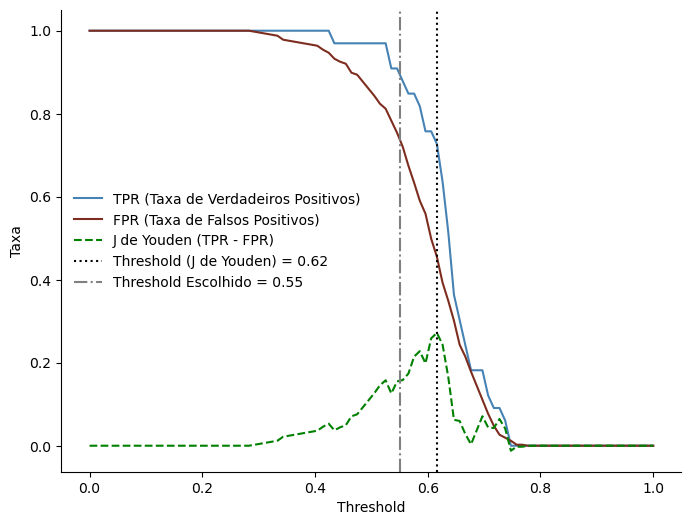

In [56]:
threshold, tpr, fpr = find_optimal_threshold(df, score_col='Pred', true_class_col='label', nome_arquivo ='New_pr_TPR_2.png')

#### Dist plots 

In [16]:
palette = ['#7D2D1F', 'steelblue']

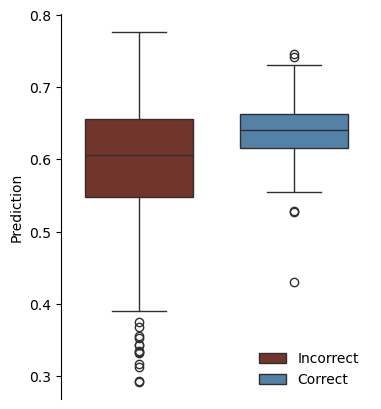

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

def criar_boxplot(df, nome_arquivo='boxplot_transparente.png'):
    """
    Cria e salva um boxplot com as seguintes características:
    - Customização das cores e largura dos boxplots
    - Ajuste do tamanho da figura
    - Remoção de elementos estéticos (eixos, título, labels)
    - Salva o gráfico como um arquivo PNG com fundo transparente
    
    Parâmetros:
    df (DataFrame): O DataFrame contendo os dados para o boxplot. 
    nome_arquivo (str): O nome do arquivo para salvar o gráfico (opcional).
    """
    # Definir o tamanho da figura
    plt.figure(figsize=(4, 5))  # Ajuste a largura e altura conforme necessário
    
    # Criar o boxplot com ajuste no parâmetro width e customização de dodge
    ax = sns.boxplot(data=df, x='label', y='Pred', hue='label', dodge=False, 
                     palette=palette, width=0.7)

    
    # Remover os eixos superiores, direito e inferior
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    # Remover os ticks e labels do eixo inferior
    ax.xaxis.set_ticks([])
    ax.set_xticklabels([])

    # Remover o título do gráfico
    ax.set_title('')
    
    # Remover o label do eixo x
    ax.set_xlabel('')
    
    # Remover o label do eixo y
    ax.set_ylabel('Prediction')
    
    # Remover o fundo da legenda e personalizar os rótulos
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles, ['Incorrect', 'Correct'], frameon=False)
    
    # Salvar o gráfico como um arquivo PNG com fundo transparente
    plt.savefig(nome_arquivo, bbox_inches='tight', dpi=300, transparent=True)


# Exemplo de uso:
criar_boxplot(df, nome_arquivo = f'simple_box_plot_{model_name}.png')


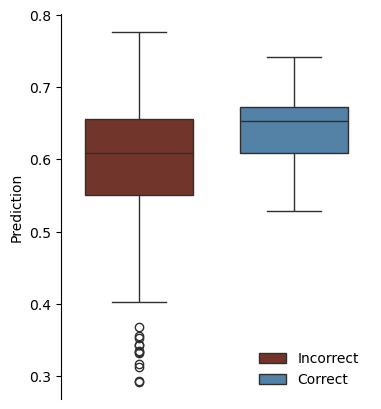

In [18]:
criar_boxplot(df[df['pose'] != "1"], nome_arquivo = f'box_plot_poses_diferente_de_1_{model_name}.png' )

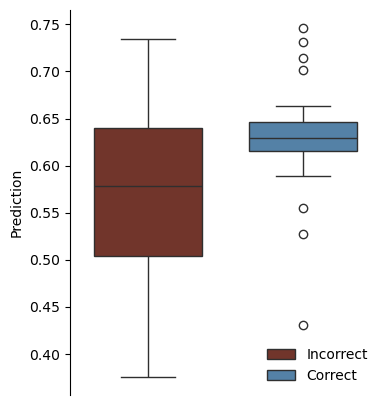

In [19]:
criar_boxplot(df[df['pose'] == "1"], nome_arquivo = f'box_plot_poses_1_{model_name}.png' )

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

def criar_kdeplot(df, nome_arquivo='kdeplot_transparente.png', palette=None):
    """
    Cria e salva um gráfico KDE com as seguintes características:
    - Customização das cores e preenchimento
    - Ajuste do tamanho da figura
    - Remoção de elementos estéticos (eixos, título, labels)
    - Salva o gráfico como um arquivo PNG com fundo transparente
    
    Parâmetros:
    df (DataFrame): O DataFrame contendo os dados para o KDE plot.
    nome_arquivo (str): O nome do arquivo para salvar o gráfico (opcional).
    palette (dict): Dicionário de paletas de cores para os diferentes hues (opcional).
    """
    # Definir o tamanho da figura
    plt.figure(figsize=(8, 6))  # Ajuste a largura e altura conforme necessário
    
    # Criar o gráfico KDE
    ax = sns.kdeplot(data=df, x='Pred', hue='label', fill=True, palette=palette)
    
    # Remover os eixos superiores, direito e inferior
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Remover o título da legenda e a borda da legenda
    legend = ax.get_legend()
    if legend:
        legend.set_title(None)
        legend.get_frame().set_visible(False)
    
    # Remover o título do gráfico
    ax.set_title('')
    
    # Remover o label do eixo x e y
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Density')
    
    # Salvar o gráfico como um arquivo PNG com fundo transparente
    plt.savefig(nome_arquivo, bbox_inches='tight', dpi=300, transparent=True)


In [21]:
palette

['#7D2D1F', 'steelblue']

In [22]:
cores = {"Incorrect": '#7D2D1F', "Correct": 'steelblue'}

In [23]:
df = df.replace( {0:"Incorrect", 1:'Correct'})

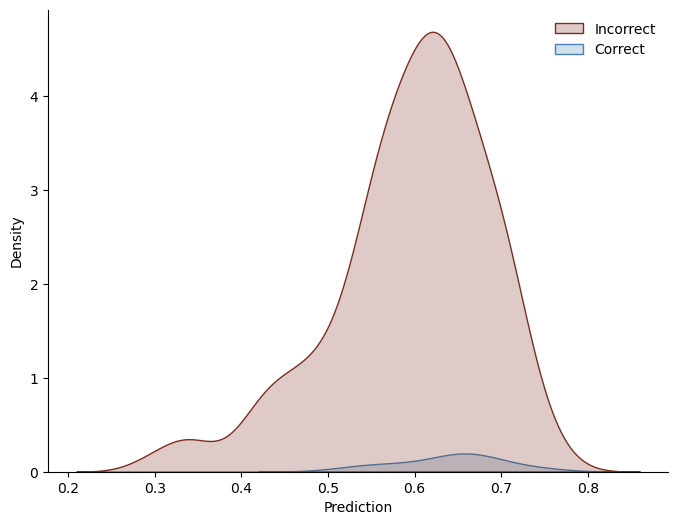

In [24]:
criar_kdeplot(df[df['pose'] != "1"], nome_arquivo=f'plot_pose_diferente_1_{model_name}.png', palette=cores)

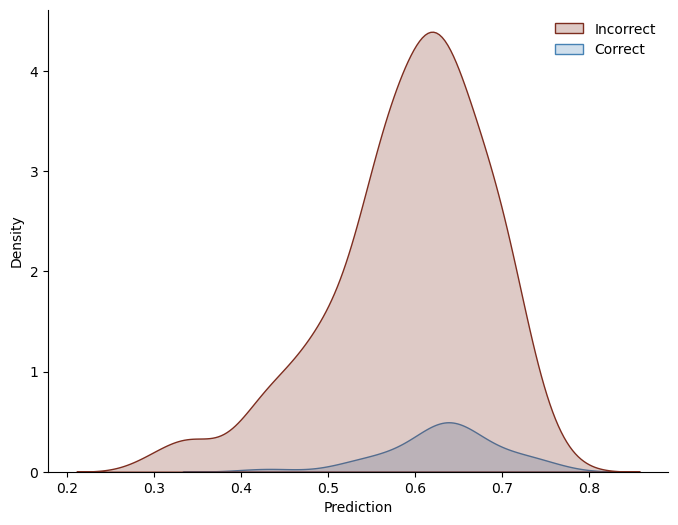

In [25]:
criar_kdeplot(df, nome_arquivo=f'plot_simple_{model_name}.png', palette=cores)

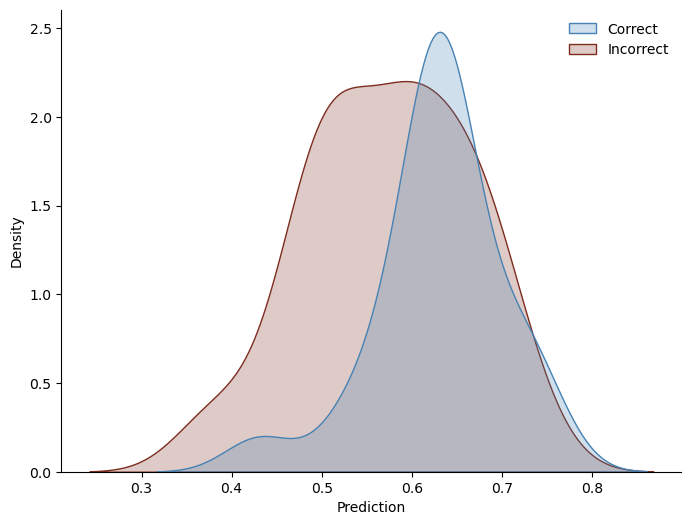

In [26]:
criar_kdeplot(df[df['pose'] == "1"], nome_arquivo=f'plot_pose_1_{model_name}.png', palette=cores)

#### Top ranked

In [27]:
df = df.sort_values(['pdb','Pred'], ascending = False)
df['label'] = df['label'].astype(int)

ValueError: invalid literal for int() with base 10: 'Incorrect'

In [ ]:
top_ranked = df.loc[df.groupby('pdb')['Pred'].idxmax()]

#### My ranking ( RMSD and Scoring): Top sorted by model pred

In [ ]:
label_counts = df.groupby('pdb')['label'].sum().sort_values(ascending = False).reset_index()

In [ ]:
pdbs_with_pose_1 = list(df[df['pose'] == '1']['pdb'])
#pdbs_teste_set_with_atleast_one_correct_post = list(label_counts[label_counts['label'] > 0 ]['pdb'])

In [ ]:
#conjunto =  set(pdbs_teste_set_with_atleast_one_correct_post) and set(pdbs_with_pose_1)
conjunto =  set(pdbs_with_pose_1)

In [ ]:
top_ranked.shape

In [ ]:
#top_ranked = top_ranked[top_ranked['pdb'].isin(conjunto)]
top_ranked[top_ranked['label'] == 1].shape[0] / top_ranked.shape[0]

In [ ]:
df['pdb'].nunique()

In [ ]:
top_ranked.shape[0]

#### Vina Fraction of top-ranked

In [ ]:
#df = df[df['pdb'].isin(conjunto)]

In [ ]:
df[(df['pose']=="1") & (df['label']==1)].shape[0] /df['pdb'].nunique()

#### Prediction distribuition 

In [ ]:
df['binary_pred'] = df['Pred'].apply(lambda val: 0 if val <= 0.5 else 1)

In [206]:
df['binary_pred'].value_counts()

KeyError: 'binary_pred'

#### Label distribuition 

In [ ]:
df['label'].value_counts(1)

#### Comparando resultados 

In [ ]:
top_ranked['label'].value_counts(1)

In [ ]:
top_ranked['label'].value_counts(1)

#### Vina score 

In [ ]:
vina_score = pd.read_csv('../Datahub/docking_scores_coreset.csv')

In [ ]:
general['label'].value_counts()

In [ ]:
#general = general[general['pdb'].isin(conjunto)]

In [ ]:
general[general['pose'] !='1']['label'].value_counts()

In [207]:
general[general['pose'] =='1']['label'].value_counts()

label
0.0    34
1.0    21
Name: count, dtype: int64

In [208]:
vina_score['pose'] = vina_score['pose'].astype(str)

In [209]:
merge = pd.merge(vina_score, general, left_on = ['pdb','pose'], right_on = ['pdb','pose'], how = 'outer').dropna()

In [210]:
merge['Pred_vina_score'] =  merge['score'] # - *merge['Pred']  

#### Best ranked 

In [211]:
df = merge.copy()

In [212]:
df.head()

,pdb,pose,score,Pred,label,Pred_vina_score
3,1a30,3,-7.199,0.603737,0.0,-7.199
8,1a30,8,-7.075,0.612946,0.0,-7.075
9,1a30,9,-6.999,0.603102,0.0,-6.999
13,1bcu,3,-7.377,0.628869,0.0,-7.377
24,1bzc,4,-9.405,0.671514,0.0,-9.405


In [213]:
df = df.sort_values(['pdb','Pred_vina_score'], ascending = False)
df['label'] = df['label'].astype(int)

In [214]:
df[df['pdb'] == '1yc1'].sort_values(['pdb','pose', 'Pred_vina_score']).head(20)

,pdb,pose,score,Pred,label,Pred_vina_score
345,1yc1,1,-9.978,0.694951,0,-9.978
347,1yc1,3,-8.326,0.697222,0,-8.326
352,1yc1,8,-7.613,0.638723,0,-7.613


In [215]:
top_ranked = df.loc[df.groupby('pdb')['Pred_vina_score'].idxmin()]

In [216]:
#top_ranked = top_ranked[top_ranked['pdb'].isin(conjunto)]
top_ranked[top_ranked['label'] == 1].shape[0] / top_ranked.shape[0]

0.15384615384615385

In [217]:
top_ranked[top_ranked['label'] == 1].shape[0]

30

In [218]:
top_ranked.shape

(195, 6)

In [219]:
general.shape

(448, 4)

In [220]:
general[(general['pose']=="1")].shape

(55, 4)

In [221]:
general[(general['pose']=="1") & (general['label']==1)].shape[0]

21

#### Report 

#### label (Pose != 1) 

0:381,
1: 12

#### Pose == 1 classe == 1

21


#### Pose != 1 classe == 1

12


Então o dataframe para ser reranquedo precisaria ter as 33 poses. Qual é esse dataframe? 

#### label (Pose == 1) 

0: 34,
1: 21

#### Results 

In [222]:
teste = df.copy()
teste = teste.sort_values('pdb')

In [223]:
teste['label'].value_counts()

label
0    397
1     33
Name: count, dtype: int64

In [224]:
198/231

0.8571428571428571

In [225]:
teste['label'].value_counts(1)

label
0    0.923256
1    0.076744
Name: proportion, dtype: float64

In [226]:
teste.shape

(430, 6)

In [227]:
pose_1 = teste[teste['pose'] =='1']

In [228]:
pose_1['label'].value_counts()

label
0    34
1    21
Name: count, dtype: int64

In [229]:
pose_1[pose_1['Pred'] > 0.6]['label'].value_counts()

label
1    16
0    14
Name: count, dtype: int64

In [230]:
pose_1[pose_1['Pred'] > 0.5]['label'].value_counts()

label
0    27
1    20
Name: count, dtype: int64

In [231]:
pose_1[pose_1['Pred'] > 0.55]['label'].value_counts(1)

label
0    0.512821
1    0.487179
Name: proportion, dtype: float64

In [232]:
palette=  ['#7D2D1F', 'steelblue']

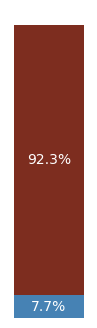

In [233]:
plot_stacked_bar_chart(teste, label_column='label', title=' ', file_name=f'grafico_empilhado_before_{model_name}.png')

In [234]:
teste['label'].value_counts()

label
0    397
1     33
Name: count, dtype: int64

In [235]:
teste[teste['Pred'] > 0.45]['label'].value_counts()

label
0    366
1     32
Name: count, dtype: int64

In [236]:
teste['label'].value_counts()

label
0    397
1     33
Name: count, dtype: int64

In [237]:
teste['label']

3       0
8       0
9       0
13      0
26      0
       ..
2491    0
2492    1
2511    0
2513    0
2518    0
Name: label, Length: 430, dtype: int64

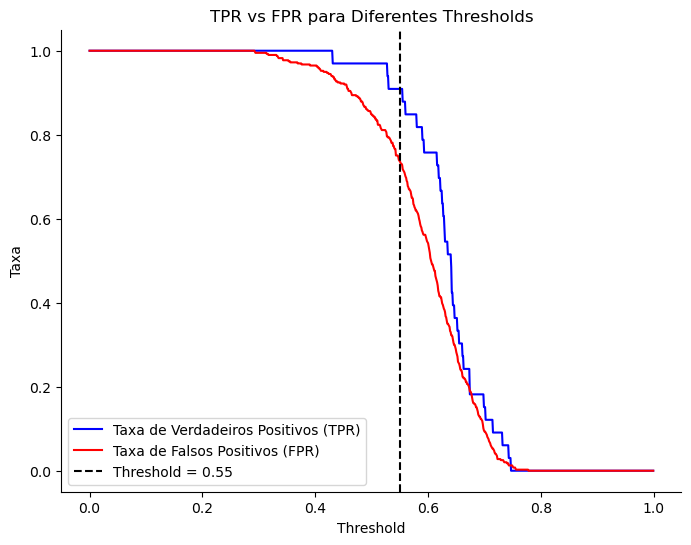

In [238]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Inicializando dicionários para TPR e FPR
tpr_values = {}
fpr_values = {}

# Calculando TPR e FPR para diferentes limiares
for threshold in np.arange(0, 1, 0.001):
    # Condição para positivos e negativos preditos corretamente/erroneamente
    tp = len(teste[(teste['Pred'] > threshold) & (teste['label'] == 1)])  # True Positives
    fp = len(teste[(teste['Pred'] > threshold) & (teste['label'] == 0)])  # False Positives
    fn = len(teste[(teste['Pred'] <= threshold) & (teste['label'] == 1)])  # False Negatives
    tn = len(teste[(teste['Pred'] <= threshold) & (teste['label'] == 0)])  # True Negatives

    # Taxa de verdadeiros positivos (TPR)
    if (tp + fn) > 0:
        tpr = tp / (tp + fn)
    else:
        tpr = 0

    # Taxa de falsos positivos (FPR)
    if (fp + tn) > 0:
        fpr = fp / (fp + tn)
    else:
        fpr = 0

    # Salvando os valores
    tpr_values[threshold] = tpr
    fpr_values[threshold] = fpr

# Convertendo para DataFrame
tpr_df = pd.DataFrame(list(tpr_values.items()), columns=['Threshold', 'TPR'])
fpr_df = pd.DataFrame(list(fpr_values.items()), columns=['Threshold', 'FPR'])

# Plotando TPR e FPR no mesmo gráfico
plt.figure(figsize=(8, 6))
plt.plot(tpr_df['Threshold'], tpr_df['TPR'], label='Taxa de Verdadeiros Positivos (TPR)', color='blue')
plt.plot(fpr_df['Threshold'], fpr_df['FPR'], label='Taxa de Falsos Positivos (FPR)', color='red')

# Adicionando uma linha vertical no threshold
Threshold = 0.55
plt.axvline(x=Threshold, color='black', linestyle='--', label=f'Threshold = {Threshold}')

# Ajustando os eixos
ax = plt.gca()  # Obtendo o objeto Axes
ax.spines['top'].set_visible(False)  # Remover o eixo superior
ax.spines['right'].set_visible(False)  # Remover o eixo direito

# Adicionando rótulos e título
plt.xlabel('Threshold')
plt.ylabel('Taxa')
plt.title('TPR vs FPR para Diferentes Thresholds')
plt.legend()

    # Salvar o gráfico como um arquivo PNG com fundo transparente
plt.savefig(f'TPR_{model_name}.png', bbox_inches='tight', dpi=300, transparent=True)
# Exibindo o gráfico
plt.show()

<Figure size 600x400 with 0 Axes>

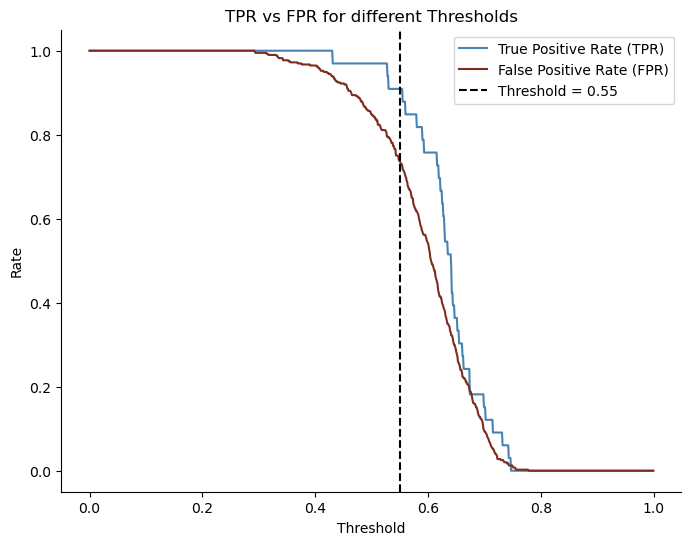

In [239]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initializing dictionaries for TPR and FPR
tpr_values = {}
fpr_values = {}

plt.figure(figsize=(6, 4)) 

# Calculating TPR and FPR for different thresholds
for threshold in np.arange(0, 1, 0.001):
    # Condition for correctly/incorrectly predicted positives and negatives
    tp = len(teste[(teste['Pred'] > threshold) & (teste['label'] == 1)])  # True Positives
    fp = len(teste[(teste['Pred'] > threshold) & (teste['label'] == 0)])  # False Positives
    fn = len(teste[(teste['Pred'] <= threshold) & (teste['label'] == 1)])  # False Negatives
    tn = len(teste[(teste['Pred'] <= threshold) & (teste['label'] == 0)])  # True Negatives

    # True Positive Rate (TPR)
    if (tp + fn) > 0:
        tpr = tp / (tp + fn)
    else:
        tpr = 0

    # False Positive Rate (FPR)
    if (fp + tn) > 0:
        fpr = fp / (fp + tn)
    else:
        fpr = 0

    # Saving the values
    tpr_values[threshold] = tpr
    fpr_values[threshold] = fpr

# Converting to DataFrame
tpr_df = pd.DataFrame(list(tpr_values.items()), columns=['Threshold', 'TPR'])
fpr_df = pd.DataFrame(list(fpr_values.items()), columns=['Threshold', 'FPR'])

# Plotting TPR and FPR on the same graph
plt.figure(figsize=(8, 6))
plt.plot(tpr_df['Threshold'], tpr_df['TPR'], label='True Positive Rate (TPR)', color='steelblue')
plt.plot(fpr_df['Threshold'], fpr_df['FPR'], label='False Positive Rate (FPR)', color='#7D2D1F')

# Adding a vertical line at the threshold
Threshold = 0.55
plt.axvline(x=Threshold, color='black', linestyle='--', label=f'Threshold = {Threshold}')

# Adjusting the axes
ax = plt.gca()  # Getting the Axes object
ax.spines['top'].set_visible(False)  # Remove the top spine
ax.spines['right'].set_visible(False)  # Remove the right spine

# Adding labels and title
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('TPR vs FPR for different Thresholds')
plt.legend()

# Saving the plot as a PNG file with a transparent background
plt.savefig(f'TPR_{model_name}.png', bbox_inches='tight', dpi=300, transparent=True)
# Displaying the plot
plt.show()

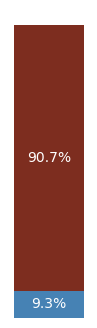

In [240]:
plot_stacked_bar_chart(teste[teste['Pred'] > 0.55], label_column='label', file_name=f'grafico_empilhado_after_{model_name}.png')

#### Pose 1 

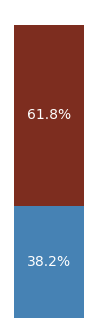

In [241]:
plot_stacked_bar_chart(pose_1, label_column='label', file_name=f'grafico_empilhado_before_pose_1_{model_name}.png')

In [242]:
pose_1['label'].value_counts()

label
0    34
1    21
Name: count, dtype: int64

In [243]:
pose_1[pose_1['Pred'] > 0.55]['label'].value_counts()

label
0    20
1    19
Name: count, dtype: int64

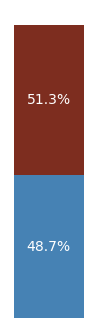

In [244]:
plot_stacked_bar_chart(pose_1[pose_1['Pred'] > 0.55], label_column='label', file_name=f'grafico_empilhado_pose_1_{model_name}.png', palette=  ['#7D2D1F','steelblue'])

## New validation 

In [174]:
name = 'NO_POSERANK_cut_4_REFINED_SET_05_06_2024.pkl'
with open(f'{config.data}/{name}', 'rb') as file:
    dataset_list_opened = pickle.load(file)
len(dataset_list_opened)

/home/lbcb00/anaconda3/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


27651

In [175]:
dataset_list_opened[:20]

[BipartiteData(edge_index=[2, 56], x_s=[56, 7], x_t=[56, 7], y=0.0, edge_attr=[56], num_nodes=112, pdb='4kfq', pose=5),
 BipartiteData(edge_index=[2, 77], x_s=[77, 7], x_t=[77, 7], y=0.0, edge_attr=[77], num_nodes=154, pdb='5byi', pose=8),
 BipartiteData(edge_index=[2, 72], x_s=[72, 7], x_t=[72, 7], y=0.0, edge_attr=[72], num_nodes=144, pdb='6e5l', pose=2),
 BipartiteData(edge_index=[2, 110], x_s=[110, 7], x_t=[110, 7], y=0.0, edge_attr=[110], num_nodes=220, pdb='5d3h', pose=5),
 BipartiteData(edge_index=[2, 126], x_s=[126, 7], x_t=[126, 7], y=1.0, edge_attr=[126], num_nodes=252, pdb='1ejn', pose=3),
 BipartiteData(edge_index=[2, 132], x_s=[132, 7], x_t=[132, 7], y=0.0, edge_attr=[132], num_nodes=264, pdb='5oa6', pose=9),
 BipartiteData(edge_index=[2, 86], x_s=[86, 7], x_t=[86, 7], y=0.0, edge_attr=[86], num_nodes=172, pdb='4u73', pose=7),
 BipartiteData(edge_index=[2, 127], x_s=[127, 7], x_t=[127, 7], y=0.0, edge_attr=[127], num_nodes=254, pdb='5kr2', pose=5),
 BipartiteData(edge_inde

In [176]:
Counter([data.y.tolist() for data in dataset_list_opened[:10000]])

Counter({0.0: 9182, 1.0: 818})

In [177]:
9182/818

11.224938875305623

In [178]:
#bipartite_no_pose_rank_cut_4_coreset_RAND_ENCODED_POSERANK
with open(f'{config.data}/NO_POSERANK_cut_4_REFINED_SET_05_06_2024.pkl', 'rb') as file:
    dataset_list_opened = pickle.load(file)
len(dataset_list_opened)

27651

In [167]:
dataset_list_opened = [data for data in dataset_list_opened if data.pdb not in pbs_to_remove_list]

In [180]:
##### Filter data list 

filtered_data_list_num_nodes = [data for data in dataset_list_opened if data.num_nodes>0]
filtered_data_list_descriptors = [data for data in filtered_data_list_num_nodes if data.x_s.shape[0] > 0 and data.x_t.shape[0] > 0]
filtered_data_list_descriptors = [data for data in filtered_data_list_descriptors if not data.x_t[1,2].isnan()] 

filtered_data_list = filtered_data_list_descriptors.copy()

label_distribuition = dict(Counter([label.y.tolist() for label in filtered_data_list]))
amount_of_graphs_used_to_train = len(filtered_data_list)

filtered_data_list_descriptors = [data for data in filtered_data_list_descriptors if not data.x_t[1,2].isnan()] 

len(filtered_data_list)

filtered_data_list[0]


loader = DataLoader(filtered_data_list[:1000], batch_size=config.model_args["batch_size"], shuffle=True, follow_batch=['x_s', 'x_t'])
criterion = BalancedBCEWithLogitsLoss(pos_weight=torch.tensor(13.5))


best_model = GATModel(input_dim=7, hidden_dim=7, batch_size=config.model_args["batch_size"])
best_model.load_state_dict(torch.load('../Model/models_pt/model_188.pt'))
best_model.eval()
# Make predictions using the best_model and criterion
predictions,true_label = predict(best_model, loader)

/home/lbcb00/anaconda3/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/tmp/ipykernel_10769/2744982026.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the l

RuntimeError: Error(s) in loading state_dict for GATModel:
	Missing key(s) in state_dict: "conv1.lin.weight". 
	Unexpected key(s) in state_dict: "conv1.lin_src.weight", "conv1.lin_dst.weight". 

In [ ]:
df = pd.DataFrame(predictions.items(), columns=['Index', 'Pred'])
df[['pdb', 'pose']] = df['Index'].apply(lambda x: pd.Series(re.findall(r"'(\w+)'", x[0]) + re.findall(r'\[(\d+)\]', x[1])))
df['label'] = list(true_label.values())
df.drop('Index', axis=1, inplace=True)

In [ ]:
df.head()

In [ ]:
pose_1 = df[df['pose'] =='1']

In [ ]:
pose_1['label'].value_counts()

In [ ]:
pose_1['label'].value_counts(1)

In [ ]:
#pose_1[pose_1['Pred'] > 0.6]['label'].value_counts()

In [ ]:
pose_1[pose_1['Pred'] > 0.6]['label'].value_counts(1)

In [ ]:
pose_1[pose_1['Pred'] > 0.5]['label'].value_counts()

In [ ]:
pose_1[pose_1['Pred'] > 0.5]['label'].value_counts(1)

In [ ]:
pose_1[pose_1['Pred'] > 0.55]['label'].value_counts(1)

In [ ]:
1802/146